In [ ]:
# MIT LICENSE
# Copyright (c) 2025 Parthib Ghosh

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [38]:
# Packages Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from xgboost import XGBClassifier
import joblib

In [7]:
# Dataset Loading:

df = pd.read_csv(
    "/kaggle/input/sms-spam-collection-dataset/spam.csv",
    encoding="latin-1",
    usecols=[0,1],
    names=["label", "message"],
    header=0
)

df["label"] = df["label"].map({"ham":0, "spam":1})
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Train-Test-Split:
X_train, X_test, y_train, y_test = train_test_split(
    df['message'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [9]:
# Vectorizer Initialization:

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.95,
    min_df=2
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

In [11]:
# Model Definition:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)
}

In [13]:
# Model Evaluation:

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    
    f1_scores = []
    roc_scores = []
    
    for train_idx, test_idx in skf.split(X_train_vec, y_train):
        
        X_tr, X_te = X_train_vec[train_idx], X_train_vec[test_idx]
        y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)
        
        f1 = f1_score(y_te, preds)
        f1_scores.append(f1)
        
        if hasattr(model, "decision_function"):
            scores = model.decision_function(X_te)
            roc = roc_auc_score(y_te, scores)
        elif hasattr(model, "predict_proba"):
            scores = model.predict_proba(X_te)[:, 1]
            roc = roc_auc_score(y_te, scores)
        else:
            roc = np.nan
        
        roc_scores.append(roc)
    
    results[name] = {
        "F1_scores": f1_scores,
        "ROC_AUC_scores": roc_scores,
        "F1_mean": np.mean(f1_scores),
        "ROC_AUC_mean": np.mean(roc_scores)
    }
summary_df = pd.DataFrame({
    model: {
        "F1_mean": results[model]["F1_mean"],
        "ROC_AUC_mean": results[model]["ROC_AUC_mean"]
    }
    for model in results
}).T

summary_df

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:11:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:11:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:11:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:11:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:11:37] WARNING: /w

,F1_mean,ROC_AUC_mean
Logistic Regression,0.812984,0.991986
Naive Bayes,0.926077,0.990304
Linear SVM,0.938377,0.993247
Random Forest,0.919685,0.992751
XGBoost,0.906155,0.980992


In [14]:
# One Way ANOVA (ROC-AUC):

f_stat_f1, p_val_f1 = f_oneway(
    results["Logistic Regression"]["ROC_AUC_scores"],
    results["Naive Bayes"]["ROC_AUC_scores"],
    results["Linear SVM"]["ROC_AUC_scores"],
    results["Random Forest"]["ROC_AUC_scores"],
    results["XGBoost"]["ROC_AUC_scores"]
)

f_stat_f1, p_val_f1

if p_val_f1 < 0.05:
    print("Reject H0: Significant difference in ROC-AUC-score among models.")
else:
    print("Fail to reject H0: No significant difference in ROC-AUC-score.")

Reject H0: Significant difference in ROC-AUC-score among models.


In [18]:
# Tukey's HSD for ROC-AUC Score:

f1_data = []
model_labels = []

for model in results:
    f1_data.extend(results[model]["ROC_AUC_scores"])
    model_labels.extend([model] * len(results[model]["ROC_AUC_scores"]))

tukey = pairwise_tukeyhsd(
    endog=f1_data,
    groups=model_labels,
    alpha=0.05
)

print(tukey)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
         Linear SVM Logistic Regression  -0.0013 0.9933 -0.0098  0.0073  False
         Linear SVM         Naive Bayes  -0.0029 0.8631 -0.0115  0.0056  False
         Linear SVM       Random Forest  -0.0005 0.9998  -0.009   0.008  False
         Linear SVM             XGBoost  -0.0123 0.0016 -0.0208 -0.0037   True
Logistic Regression         Naive Bayes  -0.0017 0.9801 -0.0102  0.0069  False
Logistic Regression       Random Forest   0.0008  0.999 -0.0078  0.0093  False
Logistic Regression             XGBoost   -0.011 0.0057 -0.0195 -0.0025   True
        Naive Bayes       Random Forest   0.0024 0.9249 -0.0061   0.011  False
        Naive Bayes             XGBoost  -0.0093 0.0263 -0.0178 -0.0008   True
      Random Forest             XGBoost  -0.0118 0.0

In [15]:
# One Way ANOVA (F1-Score):

f_stat_f1, p_val_f1 = f_oneway(
    results["Logistic Regression"]["F1_scores"],
    results["Naive Bayes"]["F1_scores"],
    results["Linear SVM"]["F1_scores"],
    results["Random Forest"]["F1_scores"],
    results["XGBoost"]["F1_scores"]
)

f_stat_f1, p_val_f1

if p_val_f1 < 0.05:
    print("Reject H0: Significant difference in F1-score among models.")
else:
    print("Fail to reject H0: No significant difference in F1-score.")

Reject H0: Significant difference in F1-score among models.


In [17]:
# Tukey's HSD for F1 Score:

f1_data = []
model_labels = []

for model in results:
    f1_data.extend(results[model]["F1_scores"])
    model_labels.extend([model] * len(results[model]["F1_scores"]))

tukey = pairwise_tukeyhsd(
    endog=f1_data,
    groups=model_labels,
    alpha=0.05
)

print(tukey)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
         Linear SVM Logistic Regression  -0.1254    0.0 -0.1511 -0.0997   True
         Linear SVM         Naive Bayes  -0.0123 0.6553  -0.038  0.0134  False
         Linear SVM       Random Forest  -0.0187 0.2518 -0.0444   0.007  False
         Linear SVM             XGBoost  -0.0322 0.0074 -0.0579 -0.0065   True
Logistic Regression         Naive Bayes   0.1131    0.0  0.0874  0.1388   True
Logistic Regression       Random Forest   0.1067    0.0   0.081  0.1324   True
Logistic Regression             XGBoost   0.0932    0.0  0.0675  0.1189   True
        Naive Bayes       Random Forest  -0.0064 0.9538 -0.0321  0.0193  False
        Naive Bayes             XGBoost  -0.0199 0.1969 -0.0456  0.0058  False
      Random Forest             XGBoost  -0.0135 0.5

In [27]:
# Linear SVM Final Training:

final_model = LinearSVC(C=1.0, class_weight="balanced")
final_model.fit(X_train_vec, y_train)
y_pred = final_model.predict(X_test_vec)

In [20]:
# Model Dump
joblib.dump(models["Linear SVM"], "Best_Model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

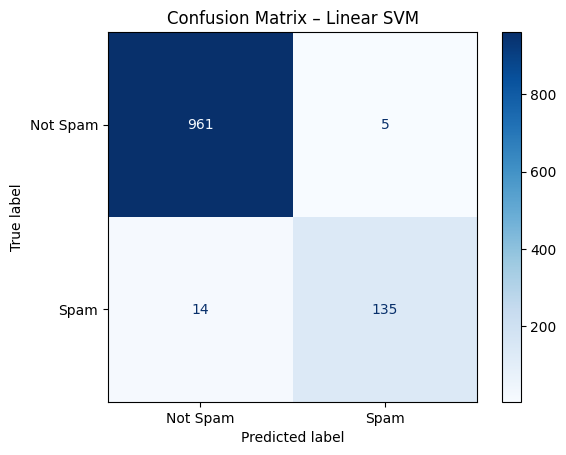

In [30]:
# Confusion Matrix Graph:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not Spam", "Spam"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Linear SVM")
plt.show()

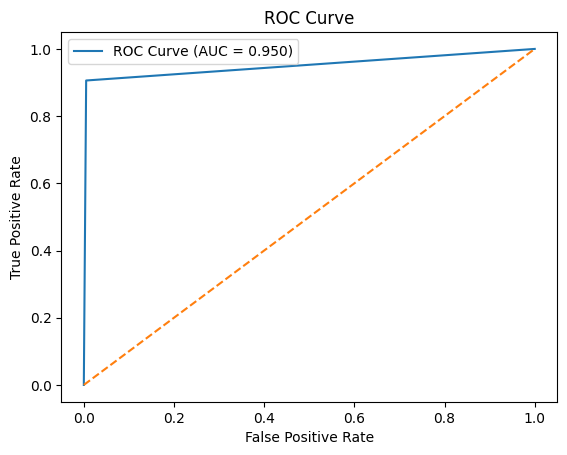

In [36]:
# ROC-AUC Curve:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

/tmp/ipykernel_55/2829737786.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


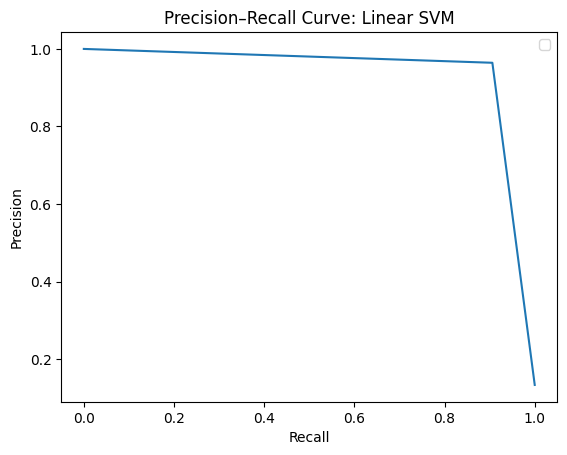

In [39]:
# Precision-Recall Curve:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve: Linear SVM")
plt.legend()
plt.show()

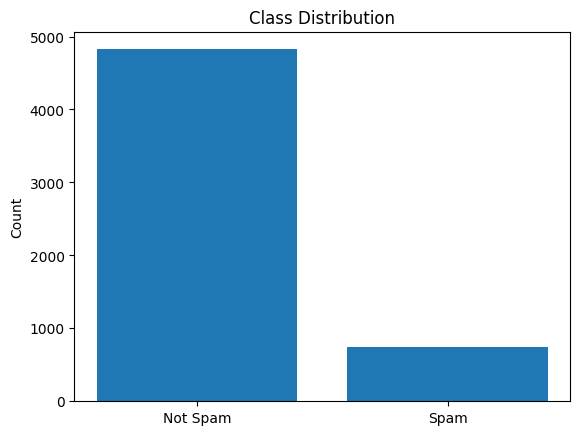

In [40]:
# Class Distribution:
labels = df['label'].value_counts()
plt.figure()
plt.bar(['Not Spam', 'Spam'], labels.values)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

In [41]:
### Conclusion

# Experimental results confirm that Linear SVM significantly outperforms
# Logistic Regression and tree-based models in terms of F1-score, while maintaining
# excellent ROC-AUC performance. Statistical hypothesis testing rejected the null
# hypothesis, indicating that observed differences among models are statistically
# significant.
# Hence, Linear SVM is recommended as the final production model for spam
# classification.